# Финальный проект по А/В тестированию

## Вводные данные

### Цель и задачи

**Цель:** Провести оценку результатов A/B-теста.

**Задачи:**

* оценить корректность проведения теста;
* проанализировать его результаты.

### Данные
* датасет с действиями пользователей;
* техническое задание;
* несколько вспомогательных датасетов.

### Техническое задание
* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие product_page
    * просмотры корзины — product_cart
    * покупки — purchase.

### План работы
1. Описание целей, задач исследования.
2. Изучение и предобработка данных: 
    * описать данные;
    * оценить (и исправить, при необходимости) пропуски и дубликаты.
3. Оценить корректность проведения теста:
    * соответствие данных требованиям технического задания
    * время проведения теста, проверить не совпадает ли тест с маркетинговыми и другими активностями.
    * проверить аудиторию теста, пересечения по группам и другим тестам
    * изучить равномерность распределения аудитории и правильность её формирования.
4. Провести исследовательский анализ данных:
    * Оценить распределение количества событий на пользователя в выборках;
    * Оценить распределение событий в выборках по дням;
    * Изучить как меняется конверсия в воронке в выборках на разных этапах.
    * Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
5. Проведите оценку результатов A/B-тестирования:
    * Оценить результаты A/B-тестирования;
    * Указать особенности данных;
    * Проверить статистическую разницу долей z-критерием.
6. Описать выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделать общее заключение о корректности проведения теста.

## Инструменты
### Библиотеки

In [1]:
# Основные
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
import math as mth

# Графики 
import matplotlib.pyplot as plt
import plotly.express as px #для построения красивой воронки
from plotly import graph_objects as go

#Опции
pd.options.display.float_format = '{:.2f}'.format #округление всех значений флота до 2 знаков после запятой
pd.set_option('max_colwidth', 200) #макс. кол-во знаков в ячейке
from IPython.display import Markdown, display, display_html

# Статистика
import scipy.stats as stats

# Предупреждения
import warnings
warnings.filterwarnings("ignore")

# Корректное отображение plotly для GitHub
import plotly.io as pio
pio.renderers.default = "png"
svg_renderer = pio.renderers["png"]
svg_renderer.scale = 1.2

### Функции

In [2]:
def read_df(way):
    """
    Чтение файла на локальном устройстве, либо в практикуме
    Передается название файла .csv
    """
    
    try:
        data = pd.read_csv('/datasets/'+way) # в практикуме
    except:
        data = pd.read_csv(way) # на моем устройстве
    
    return data

In [3]:
def full_info_check(data):
    """
    Сборка всего инфо по датасету
    """
    display(data)
    info_check(data)
    duplicate_check(data)  
    #pass_check(data)
    return

In [4]:
def info_check(data):
    """
    Общая информация о датасете
    
    Тип данных, количество строк, количество уникальных значений,
    количество пропусков, процент пропуска, 5 первых уникальных значений
    """
    display(Markdown('**Общая информация:**'))
    
    inform = data.dtypes.to_frame().rename(columns={0:'type'})
    nunique = []
    unique_first_5 = []
    
    for i in data.columns:
        nunique.append(data[i].nunique())
        unique_first_5.append(data[i].astype('str').unique().tolist()[0:5]) # str для корректного отображения времени
    
    inform['quantity'] = data.shape[0]    
    inform['nunique'] = nunique
    
    passed = data.isna().sum().to_frame().rename(columns = {0:'cnt_of_pass'}).sort_values(by = 'cnt_of_pass', ascending = True)
    passed['persent_of_pass'] = (data.isna().mean()).to_frame()
    inform = inform.merge(passed, left_index = True, right_index = True)
    
    inform['unique_first_5'] = unique_first_5
        
    display(inform.style.format({'persent_of_pass':'{:.0%}'}))
    return

In [5]:
def duplicate_check(data):
    """
    Проверка явных дубликатов
    Передается датафрейм для проверки
    """
    display(Markdown('**Дубликаты:**'))
    
    print('Количество полных строк-дубликатов: ', data.duplicated().sum())
    print('Процент дубликатов от всех данных: ', '{:.2%}'.format(data.duplicated().sum() / data.shape[0]))
    if data.duplicated().sum() != 0:
        display(data.loc[data.duplicated()])
    return

In [6]:
def pass_check(data):
    """
    Пропуски. Абсолютное и относительное значение.
    Передается датафрейм для проверки
    """
    display(Markdown('**Пропуски:**'))
    
    passed = data.isna().sum().to_frame().rename(columns = {0:'cnt_of_pass'}).sort_values(by = 'cnt_of_pass', ascending = True)
    passed['persent_of_pass'] = (data.isna().mean()).to_frame()
    display(passed.style.format({'persent_of_pass':'{:.0%}'}))
    return

In [7]:
def time_check (column):
    """
    Проверка дат
    начальная, конечная, период
    """
    print('Начальная дата: ', column.min(),
          '\nКонечная дата: ', column.max(),
          '\nПериод в: ', column.max() - column.min()
         )
    return

In [8]:
def len_check(lt):
    print('Количество пользователей в тесте: ', len(lt))
    return

In [9]:
def events(data):
    """
    Сборка таблицы с конверсией 
    все события, уникальные опльзователи, изменение конверсии
    """
    events = (data.groupby('event_name', as_index=False)
                  .agg({'event_dt': 'count', 'user_id' : 'nunique'})
                  .rename(columns={'event_dt':'all_views', 'user_id':'unic_user_views'})
                  .reset_index(drop=True)
             )
    events.loc[ len(events.index )] = ['0. Регистрация', data['user_id'].nunique(), data['user_id'].nunique()]
    events['part'] = events['unic_user_views'] / data['user_id'].nunique()
    events = events.sort_values('event_name').reset_index(drop=True)
    events['part_active'] = events['unic_user_views'] / events.at[1, 'unic_user_views']
    events['convABC'] = (events['unic_user_views'] / 
                        (events['unic_user_views'].shift(1, fill_value=events.loc[0,'unic_user_views'])))
    events['loss'] = 1 - events['convABC']
    events['convA-C'] = events['unic_user_views'] / events.loc[0,'unic_user_views']
    
    return events

In [10]:
def merge_events(data1, data2):
    data = events(data1).merge(events(data2), on='event_name', how='inner', suffixes=('_A', '_B'))
    return data

In [11]:
# z-test для определения стат различий в выборках
def hypothesis_testing(data, group1, group2, alpha = 0.05):
    """
    z-тест, адаптированный под задачу
    """
    
    data = data.reset_index(drop=True)
   
    for i in data.loc[1:5]['event_name'].unique():
        
        purchases = (data.loc[data['event_name']==i, group1].tolist()[0],
                          data.loc[data['event_name']==i, group2].tolist()[0])
        leads = (data.loc[0, group1],
                          data.loc[0, group2])
        
        p1 = purchases[0]/leads[0]
        p2 = purchases[1]/leads[1]

        p_combined = (purchases[0] + purchases[1]) / (leads[0]+leads[1])

        difference = p1 - p2

        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
        distr = stats.norm(0,1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2
        p = '{:.3f}'.format(p_value)
        diff = '{:.2%}'.format(float(data.loc[data['event_name']==i, 'diff']))
        al = '{:.3f}'.format(alpha)
        display(Markdown(f'Событие: **{i!r}** <br> Значение p_value: **{p}** <br> Значение alpha: = **{al}** <br> Отличие конверсии группы В от группы А: **{diff}** <br> Результат теста:'))
        
        if p_value < alpha:
            display(Markdown(f'<font color="red">Отвергаем нулевую гипотезу</font>: \
            между долями событий {i} в группах А и В есть значимая разница.'))
        else:
            display(Markdown(f'<font color="green">Не получилось отвергнуть нулевую гипотезу</font>, \
            нет оснований считать доли событий {i} в группах А и В разными.'))

## Загрузка

Загрузим исходные данные.

In [12]:
marketing_events = read_df('ab_project_marketing_events.csv')

In [13]:
new_users = read_df('final_ab_new_users.csv')

In [14]:
ab_events = read_df('final_ab_events.csv')

In [15]:
ab_participants = read_df('final_ab_participants.csv')

## Изучение и предобработка 
Рассмотрим каждый датасет отдельно. Изучим основные данные и выполним предобработку, если она необходима. Опишим полученные данные.

### **marketing_events**

#### Описание данных 

In [16]:
full_info_check(marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


**Общая информация:**

,type,quantity,nunique,cnt_of_pass,persent_of_pass,unique_first_5
name,object,14,14,0,0%,"['Christmas&New Year Promo', ""St. Valentine's Day Giveaway"", ""St. Patric's Day Promo"", 'Easter Promo', '4th of July Promo']"
regions,object,14,6,0,0%,"['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC', 'EU, CIS, APAC']"
start_dt,object,14,14,0,0%,"['2020-12-25', '2020-02-14', '2020-03-17', '2020-04-12', '2020-07-04']"
finish_dt,object,14,14,0,0%,"['2021-01-03', '2020-02-16', '2020-03-19', '2020-04-19', '2020-07-11']"


**Дубликаты:**

Количество полных строк-дубликатов:  0
Процент дубликатов от всех данных:  0.00%


Небольшой датасет — календарь маркетинговых событий на 2020 год:
* `name` — название маркетингового события;
* `regions` — регионы, в которых будет проводиться рекламная кампания, включает в себя:
    * APAC -Азиатско-Тихоокеанский регион,
    * EU - Евросоюз
    * N.America - Сверная Америка
    * CIS - Страны СНГ    
* `start_dt` — дата начала кампании;
* `finish_dt` — дата завершения кампании.

Данные не имеют дубликатов и пропусков, необходимо только исправить типы данных

#### Предобработка

Исправим типы данных в столбцах `start_dt` и `finish_dt` на datetime

In [17]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [18]:
time_check (marketing_events['start_dt'])

Начальная дата:  2020-01-25 00:00:00 
Конечная дата:  2020-12-30 00:00:00 
Период в:  340 days 00:00:00


In [19]:
time_check (marketing_events['finish_dt'])

Начальная дата:  2020-02-07 00:00:00 
Конечная дата:  2021-01-07 00:00:00 
Период в:  335 days 00:00:00


Данные о маркектинговых акциях предоставлены с 25 января 2020 года по 7 января 2021 года.

Данные готовы к работе

### **new_users**

#### Описание данных 

In [20]:
full_info_check(new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


**Общая информация:**

,type,quantity,nunique,cnt_of_pass,persent_of_pass,unique_first_5
user_id,object,61733,61733,0,0%,"['D72A72121175D8BE', 'F1C668619DFE6E65', '2E1BF1D4C37EA01F', '50734A22C0C63768', 'E1BDDCE0DAFA2679']"
first_date,object,61733,17,0,0%,"['2020-12-07', '2020-12-14', '2020-12-21', '2020-12-08', '2020-12-15']"
region,object,61733,4,0,0%,"['EU', 'N.America', 'APAC', 'CIS']"
device,object,61733,4,0,0%,"['PC', 'Android', 'iPhone', 'Mac']"


**Дубликаты:**

Количество полных строк-дубликатов:  0
Процент дубликатов от всех данных:  0.00%


Данные о всех пользователях, зарегистрировавшихся в интернет-магазине в период с 7 по 21 декабря 2020 года;

* `user_id` — идентификатор пользователя;
* `first_date` — дата регистрации;
* `region` — регион пользователя:
    * APAC -Азиатско-Тихоокеанский регион,
    * EU - Евросоюз
    * N.America - Сверная Америка
    * CIS - Страны СНГ   
* `device` — устройство, с которого происходила регистрация:
    * PC
    * Android
    * iPhone
    * Mac.

Данные не имеют дубликатов и пропусков, необходимо только исправить типы данных

#### Предобработка

Исправим тип данных в столбце `first_date` на datetime

In [21]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

Данные готовы к работе

### **ab_events**

#### Описание данных 

In [22]:
full_info_check(ab_events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


**Общая информация:**

,type,quantity,nunique,cnt_of_pass,persent_of_pass,unique_first_5
user_id,object,440317,58703,0,0%,"['E1BDDCE0DAFA2679', '7B6452F081F49504', '9CD9F34546DF254C', '96F27A054B191457', '1FD7660FDF94CA1F']"
event_dt,object,440317,267268,0,0%,"['2020-12-07 20:22:03', '2020-12-07 09:22:53', '2020-12-07 12:59:29', '2020-12-07 04:02:40', '2020-12-07 10:15:09']"
event_name,object,440317,4,0,0%,"['purchase', 'product_cart', 'product_page', 'login']"
details,float64,440317,4,377577,86%,"['99.99', '9.99', '4.99', '499.99', 'nan']"


**Дубликаты:**

Количество полных строк-дубликатов:  0
Процент дубликатов от всех данных:  0.00%


Данные обо всех событиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
* `user_id` — идентификатор пользователя;
* `event_dt` — дата и время события;
* `event_name` — тип события:
    * purchase - покупка;
    * product_cart - просмотр продуктовой карты;
    * product_page - просмотр страницы продукта;
    * login - вход в систему;
* `details` — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

Данные не имеют дубликатов, однако имеются пропуски и неверный тип даты.

#### Предобработка

Исправим тип данных в столбце `event_dt` и  на datetime

In [23]:
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

Изучим пропуски. посмотрим как распределены пропуски по типам события

In [24]:
pass_check(ab_events[['event_name', 'details']].pivot_table(index='event_name', dropna = False).T)

**Пропуски:**

,cnt_of_pass,persent_of_pass
event_name,,
purchase,0,0%
login,1,100%
product_cart,1,100%
product_page,1,100%


Таким образом пропуски связаны с отсутсвием дополнительных данных о всех событиях кроме purchase. 

Дополнительные данные к событию "покупка", со слов заказчика, относятся к цене покупки.

Пропуски в этих данных не нуждаются в заполнении или удалении.

Данные готовы к работе.

### **ab_participants**

#### Описание данных

In [25]:
full_info_check(ab_participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


**Общая информация:**

,type,quantity,nunique,cnt_of_pass,persent_of_pass,unique_first_5
user_id,object,18268,16666,0,0%,"['D1ABA3E2887B6A73', 'A7A3664BD6242119', 'DABC14FDDFADD29E', '04988C5DF189632E', '482F14783456D21B']"
group,object,18268,2,0,0%,"['A', 'B']"
ab_test,object,18268,2,0,0%,"['recommender_system_test', 'interface_eu_test']"


**Дубликаты:**

Количество полных строк-дубликатов:  0
Процент дубликатов от всех данных:  0.00%


Таблица участников тестов.
* `user_id` — идентификатор пользователя;
* `ab_test` — название теста:
    * recommender_system_test;
    * interface_eu_test.
* `group` — группа пользователя:
    * A; 
    * B.
    
Полных дубликатов, пропусков, ошибок в типах данных нет. 

Возможно встречаются дубликаты в user_id, но их проверка относится к проверке критериев А/В тестирования, поэтому выполним эту проверку позже.

Данные готовы для работы.

## Оценка корректности проведения теста

Продублируем для удобства технического задание

**Техническое задание:**

* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие product_page
    * просмотры корзины — product_cart
    * покупки — purchase.
    

* Требования к данным: 
    * Название теста: recommender_system_test;
    * Группы: А (контрольная), B (новая платёжная воронка);
    * Дата запуска: 2020-12-07;
    * Дата остановки набора новых пользователей: 2020-12-21;
    * Дата остановки: 2021-01-04;
    * Аудитория: 15% новых пользователей из региона EU;



Так же необходимо проверить не пересекается ли проведение теста с другими маркетинговыми событиями или другими тестами.

### Соответствие данных требованиям технического задания.

#### Название теста и группы

Еще раз посмотрим на данные, которые нам предоставлены:

In [26]:
info_check(ab_participants)

**Общая информация:**

,type,quantity,nunique,cnt_of_pass,persent_of_pass,unique_first_5
user_id,object,18268,16666,0,0%,"['D1ABA3E2887B6A73', 'A7A3664BD6242119', 'DABC14FDDFADD29E', '04988C5DF189632E', '482F14783456D21B']"
group,object,18268,2,0,0%,"['A', 'B']"
ab_test,object,18268,2,0,0%,"['recommender_system_test', 'interface_eu_test']"


Выделим пользователей, участвующих в нужном нам тесте:

In [27]:
info_check(ab_participants.query('ab_test == "recommender_system_test"'))

**Общая информация:**

,type,quantity,nunique,cnt_of_pass,persent_of_pass,unique_first_5
user_id,object,6701,6701,0,0%,"['D1ABA3E2887B6A73', 'A7A3664BD6242119', 'DABC14FDDFADD29E', '04988C5DF189632E', '482F14783456D21B']"
group,object,6701,2,0,0%,"['A', 'B']"
ab_test,object,6701,1,0,0%,['recommender_system_test']


**По техническому заданию:**

* Название теста: recommender_system_test - **<font color="green">✔ корректно</font>**; 
* Группы: А, B - **<font color="green">✔ корректно</font>**. 

#### Дата проведения теста
Посмотрим за какой период у нас имеются данные о событиях. События хранятся в таблице `ab_events`.

In [28]:
display(Markdown('**Даты проведения теста:**'))
time_check(ab_events['event_dt'])

**Даты проведения теста:**

Начальная дата:  2020-12-07 00:00:33 
Конечная дата:  2020-12-30 23:36:33 
Период в:  23 days 23:36:00


**По техническому заданию:**
- Дата запуска: 2020-12-07; **<font color="green">✔ корректно</font>**
- Дата остановки: 2021-01-04. **<font color="red">✘ не корректно - 2020-12-30, тест завершен раньше</font>**

Получается сбор данных о событиях остановлен раньше, чем это было запланировано.

#### Дата остановки набора новых пользователей

In [29]:
display(Markdown('**Даты добавления новых пользователей:**'))
time_check(new_users['first_date'])

**Даты добавления новых пользователей:**

Начальная дата:  2020-12-07 00:00:00 
Конечная дата:  2020-12-23 00:00:00 
Период в:  16 days 00:00:00


Так как в данных присутствуют пользователи из двух тестов, проверим, когда остановлен набор новых пользователей только по нашему тесту:

In [30]:
time_check(ab_participants.query('ab_test == "recommender_system_test"')
           .merge(new_users, on='user_id', how='left')
           ['first_date'])

Начальная дата:  2020-12-07 00:00:00 
Конечная дата:  2020-12-21 00:00:00 
Период в:  14 days 00:00:00


**По техническому заданию:**
* Дата завершения добавления новых пользователей: 2020-12-21  **<font color="green">✔ корректно</font>**

#### Выборка пользователей

По техническому заданию в тесте принимают участие 15% новых пользователей из региона EU.

Проверим так ли это. Посчитаем процент пользователей попавших в тестирование. 

Для этого:
* Создадим список всех новых пользователей из региона EU - `new_eu_users`

In [31]:
new_eu_users = new_users.query('region == "EU"')['user_id'].unique()

* соберем все айди пользователей, которые:
    * попали в тест recommender_system_test;
    * находятся в списке `new_eu_users`, т.е. являются пользователями из Евросоюза.
  
  получим корректный список пользователей, которые должны были оказаться в тесте - `test_1_users`.

In [32]:
ab_participants_test_1 = ab_participants.query('ab_test == "recommender_system_test" and user_id in @new_eu_users')

In [33]:
test_1_users = ab_participants_test_1['user_id'].unique()

Вычислим процент пользователей попавших в тест

In [34]:
print('Процент пользователей, участвующих в тесте: ', '{:.2%}'.format(len(test_1_users) / len(new_eu_users)))

Процент пользователей, участвующих в тесте:  13.73%


Уточним количество пользователей, участвующих в тесте:

In [35]:
len_check(test_1_users)

Количество пользователей в тесте:  6351


Техническое задание: 
* 15% новых пользователей из региона EU - **<font color="green">✔ корректно</font>**
* Ожидаемое количество участников теста 6000 - **<font color="green"> 6351 ✔ чем больше, тем лучше</font>**

### Время проведения теста

На мой взгляд время проведение теста выбрано неудачно - начало теста в начале декабря, относительно спокойное время и конец теста приходится на новогодние праздники. Пользователи могут увеличить свою активность или понизить, в зависимости от тематики площадки, на которой проводится тестирование.

In [36]:
(marketing_events
 .query('finish_dt >= @ab_events.event_dt.min() and start_dt <= @ab_events.event_dt.max()')
 .loc[marketing_events['regions'].str.contains('EU')]
)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Судя по списку маркетинговых акций время теста по тех.заданию совпадает c проведением одной акции - `Christmas&New Year Promo` (вторая акция проводится в другом регионе).

По фактически имеющимся данным тест остановлен 2020-12-30, то есть 5 дней акции вошли во время проведения теста.

Из таблицы `ab_events` получим данные тех пользователей, что вошли в тест по техническому заданию:

In [37]:
ab_events_test_1 = ab_events.query('user_id in @new_eu_users')

Посмотрим как распределены события по времени.

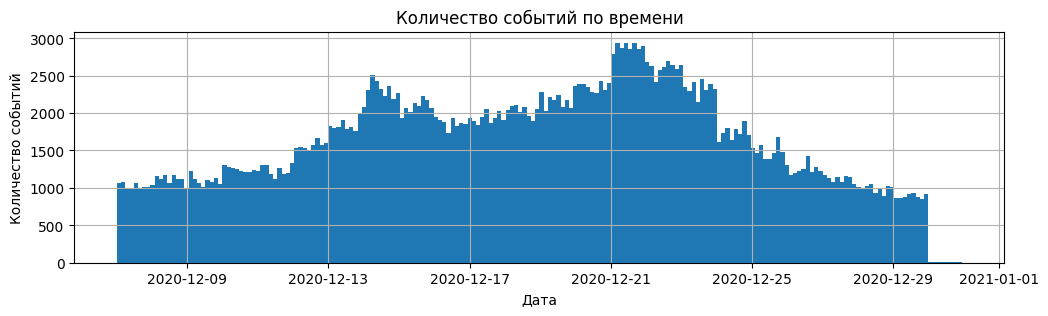

In [38]:
plt.figure(figsize=(12, 3))
ab_events_test_1['event_dt'].hist(bins=200)
plt.title('Количество событий по времени')
plt.xlabel('Дата') 
plt.ylabel('Количество событий');

Судя по графику акция от 25 декабря не вызвала волнений и всплесков активности. Так что события после 25 декабря можно оставить.

### Аудитория

Мы уже убедились в том, что пользователи, участвующие в тесте составляют 15% новых пользователей из евросоюза. Теперь проверим соответствие пользователей ругим критериям:
* нет пользователей участвующих в двух тестах одновременно;
* нет пользователей участвующих в двух группах одного теста одновременно;
* пользователи "прожили" лайфтайм в 14 дней;
* группы сформированы правильно;
* пользователи распределены по группам равномерно.

При проверке пунктов будем очищать данные и проверять количество пользователей в тесте.

Данные об участии в тестах хранятся в датасете `ab_participants`. Мы уже отсеяли пользователей которые не подходят под критейрий "пользователь из евросоюза". и создали таблицу `ab_participants_test_1`. Обновлять данные об участниках теста будем в этой таблице.

In [39]:
ab_participants_test_1

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6346,7C5C12FA1B5AB710,A,recommender_system_test
6347,91C3969B8A72B908,B,recommender_system_test
6348,E26F13A65CEAC6EA,A,recommender_system_test
6349,95401934D6D6D4FC,B,recommender_system_test


#### Пересечение пользователей по группам

Для изучения пересечений будем использовать исходную таблицу ab_participants так как в подчищенной нет участников второго теста и нам будет не выяснить пересечение групп по тестам.

In [40]:
info_check(ab_participants)

**Общая информация:**

,type,quantity,nunique,cnt_of_pass,persent_of_pass,unique_first_5
user_id,object,18268,16666,0,0%,"['D1ABA3E2887B6A73', 'A7A3664BD6242119', 'DABC14FDDFADD29E', '04988C5DF189632E', '482F14783456D21B']"
group,object,18268,2,0,0%,"['A', 'B']"
ab_test,object,18268,2,0,0%,"['recommender_system_test', 'interface_eu_test']"


Изначально мы расплагаем данными об 16666 уникальных пользователях, которые участвовали в 2 тестах и в каждом были распределены на две группы А и В.

In [41]:
user_check = ab_participants.groupby('user_id').agg({'ab_test':'nunique', 'group':'nunique'})

In [42]:
print('Количество пользователей, участвующих в двух тестах одновременно: ', user_check.query('ab_test >= 2').shape[0])

print('Количество пользователей, участвующих в одном тесте и двух группах одновременно: ', user_check.query('group >= 2 and ab_test == 1').shape[0])

Количество пользователей, участвующих в двух тестах одновременно:  1602
Количество пользователей, участвующих в одном тесте и двух группах одновременно:  0


Таким образом у нас есть пересечения по тестам, но нет пересечений по группам внутри теста.

Интересующий нас тест - `recommender_system_test`. В целом, при пересечении двух тестов нам важно что бы пользователи из изучаемого теста не попали в тестовую (В) группу второго теста. Так как в контрольной группе нет изменений, если пользователи нашего теста участвуют в контрольной группе второго теста для нас это не критично и таких пользователей мы можем оставить. Влияние на второй тест наших пользователей нас не интересует. Тогда:

**Пользователи из теста `recommender_system_test` не должны быть в группе В теста `interface_eu_test`.**

Соберем списки пользователей:
* участники теста `recommender_system_test`;
* участники группы В теста `interface_eu_test`.

In [43]:
# Пользователи теста recommender_system_test, группы А и В
test_1ab = ab_participants.query('ab_test == "recommender_system_test"')['user_id'].tolist()

# Пользователи теста interface_eu_test группы В - плохие айди
test_2b = ab_participants.query('ab_test == "interface_eu_test" and group == "B"')['user_id'].tolist()

Обновим список `test_1_users`, содержащий айди которые подходят для анализа А/В теста.

In [44]:
test_1_users = list(set(test_1ab) - set(test_2b))
len_check(test_1_users)

Количество пользователей в тесте:  5918


Количество участников теста снизилось до 5918. Это уже ниже ожидаемого в техническом задании.

Обновим таблицу `ab_participants_test_1`, в которой мы ранее отсеилии пользователей не из евросоюза.

In [45]:
ab_participants_test_1 = ab_participants_test_1.query('user_id in @test_1_users')
len_check(ab_participants_test_1)

Количество пользователей в тесте:  5568


Количество участников сократилось еще больше.

#### Распределение пользователей по группам
Изучим как распределены пользователи по группам и как эти группы формировались.

In [46]:
distribution = ab_participants_test_1.groupby('group').agg({'user_id':'count'})
distribution['part'] = distribution.apply(lambda x: x/x.sum())
display(distribution.style.format({'part':'{:.0%}'}))

,user_id,part
group,,
A,3195,57%
B,2373,43%


Одним из критериев для корректного проведения А/В-тестирования служит равное количество участников в группах. В нашем случае распределение в группах сильно слегка перекошено. Однако, в дальнейшем при проверке событий какие-то пользователи могут еще отсеяться и перекос либо усугубится, либо выровняется. Посмотрим как формировались эти группы. 
#### Формирование групп
Единственное что мы можем изучить, это даты, в которые были зарегистрированы пользователи из двух групп. Присоединим к таблице с участниками теста дату регистрации на сайте.

In [47]:
ab_participants_test_1 = ab_participants_test_1.merge(new_users[['user_id', 'first_date']], on='user_id', how='left')

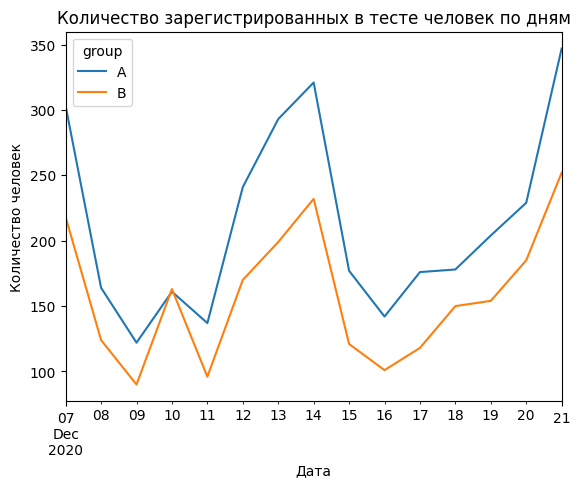

In [48]:
ab_participants_test_1.pivot_table(index='first_date', columns='group', values='user_id', aggfunc='nunique').plot()#kind='bar')
plt.title('Количество зарегистрированных в тесте человек по дням')
plt.ylabel('Количество человек')
plt.xlabel('Дата')
plt.show()

7 декабря 2020 года - понедельник. На графике можно заметить, что количество зарегистрированных пользователей каждую неделю повышается в выходные и достигает пиковых значений к понедельнику.  
Так же по графику видно, что изначально на этапе формирования групп в группу А постоянно распределялось больше человек, что неправильно.

#### Лайфтайм
Так как нас интересует изменение эффективности через 14 дней, после начала теста необходимо отфильтровать пользователей и события:
* Удалить пользователей, кто не дожил до горизонта анализа в 14 дней;
* Удалить события, превышающие горизонт анализа в 14 дней.

Ранее мы уже обновляли датасет `ab_events` до `ab_events_test_1`. Обновим до последней версии пользователей.

In [49]:
ab_events_test_1 = ab_events_test_1.query('user_id in @test_1_users')

Присоединим к этой таблице данные о регистрации пользователей. Нам понадобятся столбцы `user_id` и `first_date`.

Затем создадим столбец с временем, через которое было совершено событие с момента регистрации. 

И удалим все события, которые совершали пользователи позже, чем через 14 дней.

In [50]:
ab_events_test_1 = ab_events_test_1.merge(new_users[['user_id', 'first_date']], on='user_id', how='left')
ab_events_test_1['dif_time'] =  ab_events_test_1['event_dt'] - ab_events_test_1['first_date']
ab_events_test_1 = ab_events_test_1.query('dif_time < "15 days"')

Посмотрим у скольки пользователей остались события:

In [51]:
print('Количество активных пользователей: ', ab_events_test_1['user_id'].nunique())
print('Количество всех пользователей в тесте: ', ab_participants_test_1['user_id'].nunique())

Количество активных пользователей:  3050
Количество всех пользователей в тесте:  5568


Так как нам необходимо что бы пользователи прожили 14 дней мы можем удалить тех, кто зарегистрировался в системе позже, чем 2020-12-17 00:00:00, т.е. лайфтайм с этой даты будет составлять менее 14 дней. Изначально при планировании теста и составления технического задания так и было задумано: разница между датой остановки набора новых пользователей и датой остановки теста составляла 14 дней. Однако из-за того что тест остановили преждевременно в тесте появились пользователи, которые не успели прожить 14 дней. Посмотрим сколько активных пользователей у нас останется, если мы удалим не проживших 14 дней:

In [52]:
print('Количество активных пользователей: ', ab_events_test_1.query('first_date < "2020-12-17 00:00:00"')['user_id'].nunique())

Количество активных пользователей:  1675


Таким образом мы бы сократили количество пользователей еще практически вдвое. Предположим, что влияние тестовых изменений на пользователя одинаково во время всего лайфтайма, поэтому не будем удалять таких пользователей, и все же учтем их в анализе теста.

Соберем итоговую таблицу для анализа результатов тестирования. Напомним, в тесте присутсвуют пользователи, которые кроме регистрации не совершали никаких действий на сайте. Для таблицы возьмем только необходимые столбцы.

In [53]:
data = (ab_events_test_1[['user_id','event_dt','event_name']]
        .merge(ab_participants_test_1[['user_id','group','first_date']], 
               on='user_id', 
               how='right'
              )
       )
info_check(data)

**Общая информация:**

,type,quantity,nunique,cnt_of_pass,persent_of_pass,unique_first_5
user_id,object,22552,5568,0,0%,"['D1ABA3E2887B6A73', 'A7A3664BD6242119', 'DABC14FDDFADD29E', '04988C5DF189632E', '482F14783456D21B']"
event_dt,datetime64[ns],22552,13373,2518,11%,"['2020-12-07 14:43:27', '2020-12-07 14:43:29', '2020-12-20 15:46:06', '2020-12-21 00:40:59', '2020-12-25 05:19:45']"
event_name,object,22552,4,2518,11%,"['purchase', 'product_cart', 'product_page', 'login', 'nan']"
group,object,22552,2,0,0%,"['A', 'B']"
first_date,datetime64[ns],22552,15,0,0%,"['2020-12-07', '2020-12-20', '2020-12-08', '2020-12-14', '2020-12-16']"


И посмотрим распределение пользователей по группам для формирования итоговых выводов.

In [54]:
distribution = data.groupby('group').agg({'user_id':'count'})
distribution['part'] = distribution.apply(lambda x: x/x.sum())
display(distribution.style.format({'part':'{:.0%}'}))

,user_id,part
group,,
A,16767,74%
B,5785,26%


Потрясающе неравномерное распределение.

### Вывод

Из оценки теста следует:

**Оценка соответсвия техническому заданию:** 
<font color="red">Тест не удовлетворяет всем пунктам технического задания</font>


| Требования к данным                         | Техническое задание       | Фактические данные | Комментарий |
|---------------------------------------------|---------------------------|----------|----------|
| Название теста                              | recommender_system_test   | <font color="green">recommender_system_test</font>   |
| Группы                                      | А и В                     | <font color="green">А и В</font>   |
| Дата запуска                                | 2020-12-07                | <font color="green">2020-12-07</font>   |
| Дата остановки набора новых пользователей   | 2020-12-21                | <font color="green">2020-12-21</font>   ||
| Дата остановки                              | 2021-01-04                | <font color="red">2020-12-30</font>   |Тест остановлен за 5 дней до планируемой даты остановки |
| Аудитория                       | 15% новых пользователей из региона EU | <font color="green">15% новых пользователей из региона EU</font>   |


При оценнке исходных данных обнаружено несоответсвие данных техническому заданию:

* проведение теста пересекается с проведением промоакций, и вообще выпадает на новогодние праздники, где поведение пользователей непредсказуемо;
* количество пользователей, которые были зарегистрированы для участия в тесте - 6351, ровно 15% от новых пользователей из Евросоюза. Однако при дальнейшем исследовании пользователи отсеивались:
    * удалены пользователи, которые находятся в тестовой группе другого теста;
    * удалены события, которые были совершены после горизонта анализа в 14 дней, с событиями удалились пользователи, которые не проявляли активность в первые 14 дней после регистрации.
  в итоге в данных теста осталось 1675 человек;
* При формировании групп ежедневно данные распределялись неравномерно.<br>Распределение до отсеивания неподходящих пользователей: 
    * 57% пользователей в группе А
    * 43% в группе B.
    
  после удаления событий и пользователей, чей лайфтайм превышает 14 дней :
    * 74% пользователей в группе А
    * 26% в группе B.
    
Тестирование проведено некорректно, результаты, полученные в результате такого теста следует подвергать большому сомнению.

## Исследовательский анализ данных
Мы уже выяснили что пользователи распределены по группам некорректно, изучим как распределены события по группам. Для этого посмотрим какие события вообще рассматриваются в тесте:

In [55]:
data['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login', nan],
      dtype=object)

* `purchase` - покупка;
* `product_cart` - просмотри продуктовой карточки;
* `product_page` - просмотр корзины;
* `login` - вход в систему.

Переименуем события для удобства и корректного отображения их порядка. Создадим словарь значений для переименования:

In [56]:
rename_dict = {'login':'1. Вход в систему',                
               'product_page':'2. Просмотр продуктовой карточки',
               'product_cart':'3. Просмотр корзины', 
               'purchase':'4. Покупка'
              }
data['event_name'] = data['event_name'].map(dict(rename_dict))

### Количество событий на пользователя
Посмотрим как события распределены по пользователям. Для этого обратимся к функции (перенесем её в начало работы для удобства навигации), которая построит следующую таблицу:
* event_name - название события;
* all_views - количество событий;
* unic_user_views - количество уникальных пользователей, совершивших событие;
* part - часть пользователей от числа пользователей в выборке;
* part_active - перерасчет на активных пользователей.

Добавим в таблицу событие "0. Регистрация", что бы отследить конверсию зарегистрировавшихся пользователей. Это событие единожды совершил каждый пользователь.

In [57]:
group_events = merge_events(data.query('group =="A"'), data.query('group =="B"'))
group_events

,event_name,all_views_A,unic_user_views_A,part_A,part_active_A,convABC_A,loss_A,convA-C_A,all_views_B,unic_user_views_B,part_B,part_active_B,convABC_B,loss_B,convA-C_B
0,0. Регистрация,3195,3195,1.00,1.40,1.00,0.00,1.00,2373,2373,1.00,3.08,1.00,0.00,1.00
1,1. Вход в систему,7018,2279,0.71,1.00,0.71,0.29,0.71,2036,770,0.32,1.00,0.32,0.68,0.32
2,2. Просмотр продуктовой карточки,4514,1476,0.46,0.65,0.65,0.35,0.46,1074,429,0.18,0.56,0.56,0.44,0.18
3,3. Просмотр корзины,2114,686,0.21,0.30,0.46,0.54,0.21,542,214,0.09,0.28,0.50,0.50,0.09
4,4. Покупка,2205,734,0.23,0.32,1.07,-0.07,0.23,531,219,0.09,0.28,1.02,-0.02,0.09


Сравним распределение событий по группам

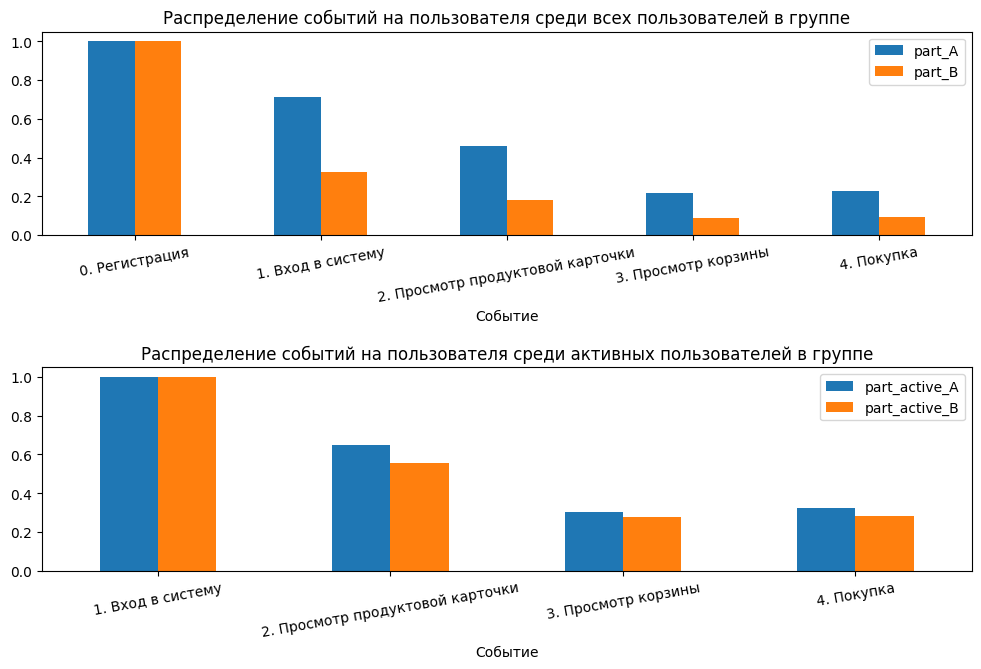

In [58]:
plt.figure(figsize=(12, 7))

group_events.plot(x='event_name', 
                  y = ['part_A','part_B'], 
                  kind='bar', 
                  ax=plt.subplot(2, 1, 1),
                  rot=10)
plt.xlabel('Событие')
plt.title('Распределение событий на пользователя среди всех пользователей в группе')

group_events.query('event_name != "0. Регистрация"').plot(x='event_name',
                                                          y = ['part_active_A','part_active_B'], 
                                                          kind='bar',
                                                          ax=plt.subplot(2, 1, 2), 
                                                          rot=10)
plt.subplots_adjust(hspace = 0.65)
plt.xlabel('Событие')
plt.title('Распределение событий на пользователя среди активных пользователей в группе');

Очевидно, большая часть пользователей из группы В теряется после регистрации и не переходит к просмотру продуктовых карточек. В группе А до входа в систему доходит 71% пользователей, в группе В только 32%.

Если брать для рассмотрения только активных пользователей в тесте, картина в распределении событий не меняется в положительную сторону для группы В.

Группа В слегка отстает по количеству всехсобытий.

### Распределение числа событий в выборках по дням
Изучим как события распределены в выборках, напомним, что выборки неравномерные, группа А больше группы В.

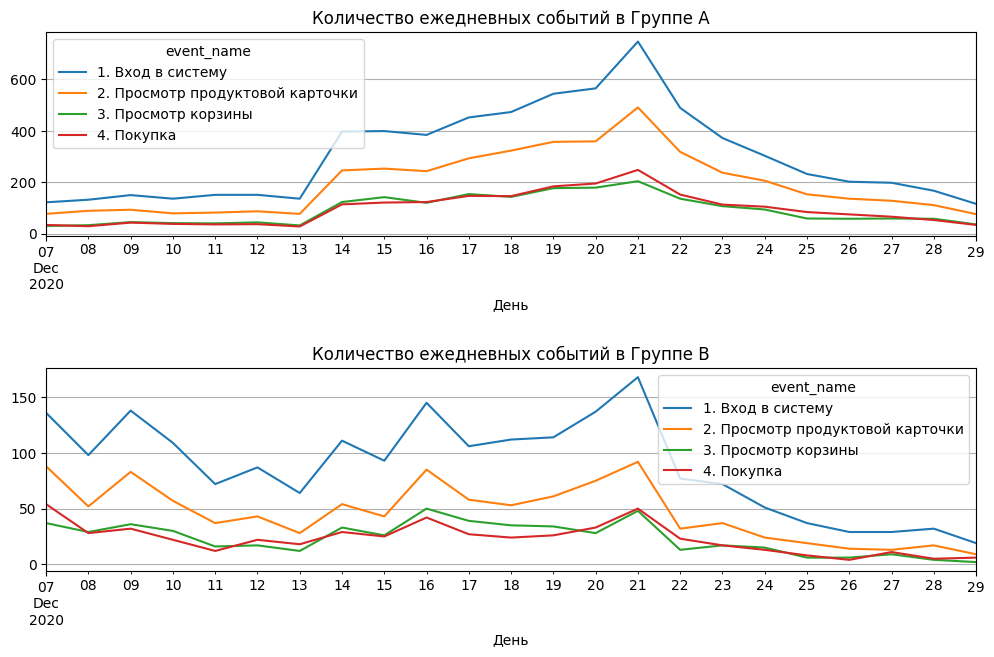

In [59]:
data['event_day'] = data['event_dt'].astype('datetime64[D]')

plt.figure(figsize=(12, 7))

event_day_A = (data.query('group =="A"')
                  .pivot_table(index='event_day', columns='event_name', values='user_id', aggfunc='count')
                 )
event_day_A.plot(grid=True, ax=plt.subplot(2, 1, 1))
plt.xlabel('День')
plt.title('Количество ежедневных событий в Группе А')

event_day_B = (data.query('group =="B"')
                  .pivot_table(index='event_day', columns='event_name', values='user_id', aggfunc='count')
                 )
event_day_B.plot(grid=True, ax=plt.subplot(2, 1, 2))
plt.subplots_adjust(hspace = 0.65)
plt.xlabel('День')
plt.title('Количество ежедневных событий в Группе B');

У группы А наблюдается недельная низкая активность и резкое увеличение событий на вторую неделю и третью неделю теста, связанную с повышенным притоком вновь зарегистрированных пользователей. 21 декабря была завершена регистрация пользователей в тесте и активность у пользователей упала. Таким образом можно сделать вывод о том, что наибольшую активность пользователи проявляют в момент регистрации, то есть регистрируются для совершения какой-то конкретной покупки.

Распределение событий у группы В более равномерное на всем изучаемом промежутке до момента остановки регистрации новых пользователей в тесте. После остановки так же наблюдается сильный спад активности пользователей.

### Конверсия в воронке 

Соберем таблицу с уникальными пользователями для каждого последовательного события:

Для наглядности построим продуктовую воронку и посмотрим, какой процент пользователей переходил на следующий этап

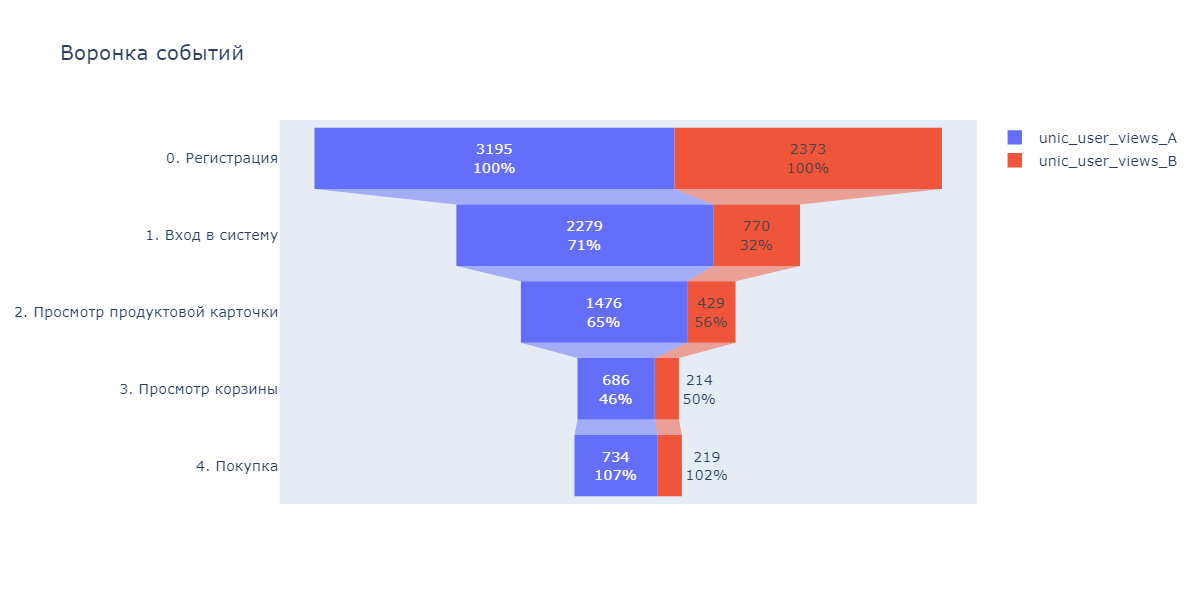

In [60]:
fig = go.Figure()

for i in ['unic_user_views_A', 'unic_user_views_B']:
    fig.add_trace(go.Funnel(
        name = i,
        y = group_events['event_name'].unique(),
        x = group_events[i],
        textinfo = "value+percent previous"))
fig.update_layout(
                  height=500,
                  width=1000)
fig.update_layout(title="Воронка событий")
fig.show()

Самая большая потеря пользователей произошла после регистрации. Необходимо выяснить почему пользователи из тестовой группы после регистрации не переходят к непостредственному функционалу сайта.

Так же у группы В наблюдается более низкая конверсия в просмотр карточек товаров.

Чуть лучше у группы В обстоят дела с переходом в событие "Просмотр корзины".

Доля пользователей, перешедших из корзины к оплаты в обеих группах составляет более 100%, вероятно в продуктовой карточке есть не только кнопка "Добавить в корзину", но и "Купить сейчас". С событием "Просмотр корзины" кажется, что конверсия в покупку у группы В хуже, чем у группы А.

Посмотрим как будет выглядеть продуктовая воронка без события "Просмотр корзины".

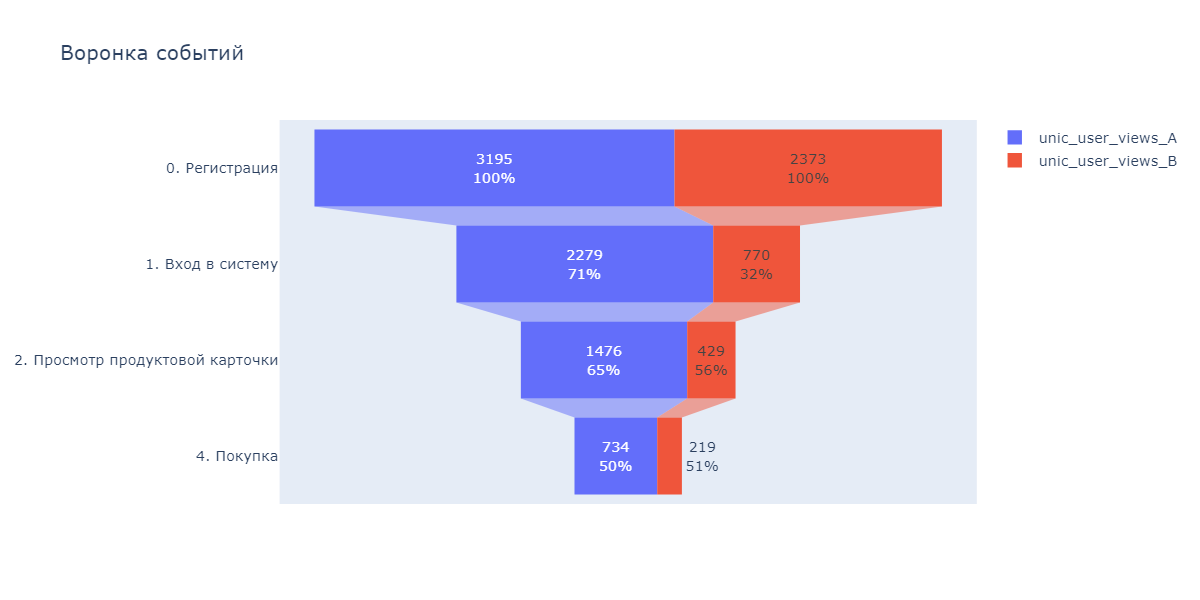

In [61]:
fig = go.Figure()

for i in ['unic_user_views_A', 'unic_user_views_B']:
    fig.add_trace(go.Funnel(
        name = i,
        y = group_events.query('event_name != "3. Просмотр корзины"')['event_name'].unique(),
        x = group_events.query('event_name != "3. Просмотр корзины"')[i],
        textinfo = "value+percent previous"))
fig.update_layout(
                  height=500,
                  width=1000)
fig.update_layout(title="Воронка событий")
fig.show()

А вот если убрать из воронки событие "Просмотр корзины", то конверсия в покупку у группы В на один процент выше, чем у группы А.

Посмотрим на разницу конверсии пользователей по группам:

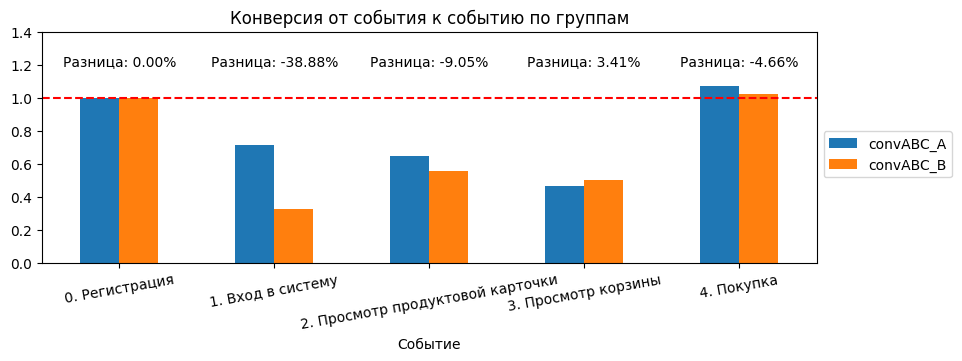

In [62]:
group_events['diff'] = group_events['convABC_B'] - group_events['convABC_A']
group_events.plot(x='event_name', 
                 y = ['convABC_A','convABC_B'], 
                 kind='bar', rot=10, figsize=(10,3))

for i, val in enumerate(group_events['diff'].values):
    plt.text(i, 1.2, 'Разница: '+'{:.2%}'.format(val), 
             horizontalalignment='center',
             fontdict={'fontweight':300,'size':10}
            )

plt.axhline (y=1, color='red', linestyle='--') 
plt.ylim(0,1.4)
plt.legend(bbox_to_anchor=(1, 0.6))
plt.xlabel('Событие')
plt.title('Конверсия от события к событию по группам');

Таким образом небольшая положительная конверсия наблюдается у группы В только при переходе из продуктовой карточки в корзину.

###  Вывод

**Ожидаемые результаты:**
<font color="red">не достигнуты</font>

| Требования к данным                         | Ожидаемый результат       | Фактический результат | Комментарий |
|---------------------------------------------|---------------------------|----------|----------|
| Ожидаемое количество участников теста | 6000 | <font color="green">6351</font> |Несмотря на общее число зарегистрированных в тест пользователей, после проверки пользователей на пересечения с другим тестом в выборке осталось <font color="red">5568</font> пользователей, из них только <font color="red">3050</font> пользователей были активными и имеют хотя бы одно событие.|
| Ожидаемый эффект | За 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%| <font color="red">Конверсия упала, большой процент пользователей в тестовой группе потерялись сразу после регистрации</font>||

Большая часть пользователей из группы В (71% против 32% в группе А) теряется после регистрации и не переходит к просмотру продуктовых карточек. Это сильно влияет на распределение количества событий по пользователям внутри группы. При учете всех пользователей группа В сильно остает по среднему количеству событий на человека. Если же учитывать только активных пользователей, то отставание группы В по среднему числу значительно меньше, от 9 (просмотр карточек) до 2 (просмотр корзины) процентов.  

Распределение событий у группы В более равномерное на всем изучаемом промежутке до момента остановки регистрации новых пользователей в тесте. Затем у обеих групп начинается резкий спад активности, связанный с остановкой регистрации новых пользователей. Вероятно пользователи чаще регистрируются для совершения какой-то конкретной покупки.

Самая большая потеря в конверсии пользователей произошла после регистрации. Необходимо выяснить почему 2/3 пользователей из тестовой группы после регистрации не переходят к непостредственному функционалу сайта.

Так же у группы В наблюдается более низкая конверсия в просмотр карточек товаров.

Чуть лучше у группы В, чем у группы А, обстоят дела с переходом в событие "Просмотр корзины".

Доля пользователей, перешедших из корзины к оплаты в обеих группах составляет более 100%, вероятно в продуктовой карточке есть не только кнопка "Добавить в корзину", но и "Купить сейчас". С событием "Просмотр корзины" кажется, что конверсия в покупку у группы В хуже, чем у группы А. Однако если убрать событие "Просмотр корзины" ситуация обратная, но не слишком то и хорошая.


## Оценка результатов A/B-тестирования:

При оценке результатов A/B-тестирования следует учесть, что данные для его проведения были собраны некорректно. 

* Имеются внешние предсказуемые влияния в виде промо-акции и предновогодних дней, когда активность пользователей, предположительно повышается;
* распределение пользователей по группам было осуществленно неравномерно;
* тест был остановлен раньше времени;
* треть пользователей из тестовой группы не залогинились на сайте после регистрации, есть вероятность наличия дополнительных проблем с внедрением улучшеной рекоммендательной системы. 

**При анализе продуктовой воронки не наблюдается ожидаемой эффективности**:

* после внедрения улучшеной рекомендательной системы конверсии покупателей не улучшились на 10%, а даже уменьшились по всем событиям, крмое события "просмотр корзины".

### Проверьте статистическую разницу долей z-критерием.

Проведем двусторонний **z-test** с показателем статистической значимости **alfa = 0.05** и выясним, можно ли вообще считать разницу между конверсиями у двух групп статистически значимой.

Тест проводим с учетом всех пользователей, прошедших фильтры и попавших в выборку, независимо от того, совершали они действия или нет.

**Гипотезы:**

**Нулевая гипотеза**: Статистических различий в долях пользователей, совершивших событие между группами **А** и **В** нет.

**Альтернативная**: Статистически значимые различия в долях пользователей, совершивших событие между группами **А** и **В** есть.

In [63]:
hypothesis_testing(group_events.loc[1:5], 'unic_user_views_A', 'unic_user_views_B')

Событие: **'2. Просмотр продуктовой карточки'** <br> Значение p_value: **0.000** <br> Значение alpha: = **0.050** <br> Отличие конверсии группы В от группы А: **-9.05%** <br> Результат теста:

<font color="red">Отвергаем нулевую гипотезу</font>:             между долями событий 2. Просмотр продуктовой карточки в группах А и В есть значимая разница.

Событие: **'3. Просмотр корзины'** <br> Значение p_value: **0.225** <br> Значение alpha: = **0.050** <br> Отличие конверсии группы В от группы А: **3.41%** <br> Результат теста:

<font color="green">Не получилось отвергнуть нулевую гипотезу</font>,             нет оснований считать доли событий 3. Просмотр корзины в группах А и В разными.

Событие: **'4. Покупка'** <br> Значение p_value: **0.051** <br> Значение alpha: = **0.050** <br> Отличие конверсии группы В от группы А: **-4.66%** <br> Результат теста:

<font color="green">Не получилось отвергнуть нулевую гипотезу</font>,             нет оснований считать доли событий 4. Покупка в группах А и В разными.

Хоть мы и получили значимую разницу в конверсии события "Просмотр продуктовой карточки", конверсия у группы В ниже, чем у группы В на 9%. 
Значимой разности при положительном изменении конверсии мы не получили. 

Таким образом с учетом всех особенностей внедрение улучшенной рекомендательной системы не принесло положительных результатов.

Так как мы проводим множественное тестирование, а именно 3 теста, чтобы снизить вероятность ложнопозитивного результата применим поправку Бонферрони и посмотрим как изменится результат.

In [64]:
bonferroni_alpha = 0.05 / 3
bonferroni_alpha

0.016666666666666666

In [65]:
hypothesis_testing(group_events.loc[1:5], 'unic_user_views_A', 'unic_user_views_B', alpha = bonferroni_alpha)

Событие: **'2. Просмотр продуктовой карточки'** <br> Значение p_value: **0.000** <br> Значение alpha: = **0.017** <br> Отличие конверсии группы В от группы А: **-9.05%** <br> Результат теста:

<font color="red">Отвергаем нулевую гипотезу</font>:             между долями событий 2. Просмотр продуктовой карточки в группах А и В есть значимая разница.

Событие: **'3. Просмотр корзины'** <br> Значение p_value: **0.225** <br> Значение alpha: = **0.017** <br> Отличие конверсии группы В от группы А: **3.41%** <br> Результат теста:

<font color="green">Не получилось отвергнуть нулевую гипотезу</font>,             нет оснований считать доли событий 3. Просмотр корзины в группах А и В разными.

Событие: **'4. Покупка'** <br> Значение p_value: **0.051** <br> Значение alpha: = **0.017** <br> Отличие конверсии группы В от группы А: **-4.66%** <br> Результат теста:

<font color="green">Не получилось отвергнуть нулевую гипотезу</font>,             нет оснований считать доли событий 4. Покупка в группах А и В разными.

Выводы не изменились, проверка выполнена корректно

## Выводы 

по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. 

**Проведение A/B-тестирования:** 

<font color="red">Выборка не удовлетворяет криетриям корректного A/B-тестирования</font>

Похоже, что при проведении теста не были проверены следующие пункты:
* инструмент «деления» трафика работает безошибочно;
* данные отправляются в системы аналитики корректно.

Таким образом пользователи оказались неравномерно распределены среди групп А и В. 

Не учтен вероятный всплеск активности покупателей перед новым годом, а так же всплеск активности, связанный с проведением маркетинговых акций.

Тест был остановлен досрочно, всвязи с чем не у всех пользователей набрался лайфтайм в 14 дней. Если бы мы отсекали пользователей, которые не дожили до горизонта анализа в выборке был бы лишь 1651 пользователь.

**Оценка результатов A/B-тестирования:**

По итогам проведения теста <font color="red">ожидаемой эффективности не наблюдается</font>. После внедрения улучшеной рекомендательной системы конверсии покупателей не улучшились на 10%, а даже уменьшились по всем событиям, крмое события "просмотр корзины".

**Рекомендации:**

Рекомендуется исправить все ошибки в проведении теста и, при необходимости, провести его снова.

Ошибки:

- Несвоевременная остановка теста и набора пользователей;
- наблюдаются пересечения изучаемого теста с другим тестом по пользователям;
- распределение пользователей по группам неравномерное;
- не учтено влияние праздничных дней и проведения промо-акций.
